# Sotavento: Problema de Clasificación
En el siguiente cuaderno se analiza el rendimiento del modelo escogido para producciones altas y bajas de energía
Tras ello, se transforma el problema original de predicción de producción de la energía en un problema de clasificación.

In [54]:
#Importación de librerías
import pandas as pd
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor


In [52]:
#Importación de datos del modelo final de regresión. 
import pickle
#with open ('modelo_final.pkl', 'rb') as file:
   # final_model = pickle.load(file)

ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

# 1. Medición de rendimiento del modelo de regresión.
Tal y como nos indica el enunciado, se considera como producción alta aquella mayor que el tercer cuantil, y baja en otro caso. 
Para ello, primero añadimos una columna a nuestro dataset en función del valor de la energía. Esta nos permitirá realizar las mediciones de error y actuará como etiqueta en nuestro problema de clasificación más adelante. 
 

In [35]:
#Importación de dataset
wind_ava=pd.read_csv('wind_ava.csv.gz', compression = "gzip")

wind_ava['datetime']= pd.to_datetime(wind_ava['datetime'])
wind_ava = wind_ava.set_index('datetime')

for c in wind_ava.columns:
    if not c.endswith('.13') and c != 'datetime' and c != 'energy':
        wind_ava = wind_ava.drop(c, axis = 1)
print("El tamaño del dataset es: ", wind_ava.shape)

El tamaño del dataset es:  (4748, 23)


In [36]:
wind_ava.head()

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,...,280.473098,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617
2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,...,278.286616,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469
2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,...,277.206490,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748
2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,...,280.926600,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478
2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,...,277.363875,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114


In [39]:
#Inserción de la nueva columna. 
labels= []
q= wind_ava['energy'].quantile(0.75)
print(q)
#Iteramos 1 vez por fila
for i in wind_ava['energy']:
    if i > q:
        labels.append("High")
    else:
        labels.append("Low")
    print(i, labels[-1])


1089.375
402.71 Low
696.8 Low
1591.15 High
1338.62 High
562.5 Low
232.3 Low
329.95 Low
960.51 Low
194.62 Low
358.51 Low
808.8 Low
93.36 Low
155.94 Low
0.01 Low
4.85 Low
218.76 Low
906.21 Low
201.42 Low
641.34 Low
1524.05 High
943.85 Low
791.4 Low
413.33 Low
170.43 Low
216.48 Low
122.58 Low
327.31 Low
1434.55 High
997.24 Low
1011.12 Low
747.11 Low
761.06 Low
1164.17 High
1410.9 High
1399.9 High
707.84 Low
322.78 Low
243.41 Low
62.85 Low
242.45 Low
193.79 Low
897.88 Low
738.87 Low
652.09 Low
191.28 Low
399.54 Low
1473.27 High
1448.47 High
1620.97 High
108.42 Low
436.67 Low
332.56 Low
6.82 Low
159.31 Low
466.69 Low
1397.77 High
1514.19 High
2101.22 High
838.6 Low
727.37 Low
374.25 Low
960.49 Low
373.42 Low
218.45 Low
158.12 Low
134.68 Low
357.05 Low
279.42 Low
839.06 Low
692.55 Low
268.49 Low
288.9 Low
109.88 Low
256.34 Low
1609.87 High
2279.76 High
2320.36 High
1985.0 High
1968.71 High
1489.33 High
934.96 Low
1315.66 High
896.95 Low
786.17 Low
2137.19 High
2352.94 High
907.34 Low
2215.52

In [40]:
#Añadimos la nueva columna al dataset
wind_ava['label']= labels
wind_ava.head()

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13,label
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,...,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617,Low
2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,...,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469,Low
2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,...,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748,High
2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,...,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478,High
2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,...,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114,Low


In [45]:
#Crear los nuevos conjuntos para cada segmento: valores altos y bajos.
train= wind_ava[wind_ava.index.map(lambda x: x.year) < 2009]
test= wind_ava[wind_ava.index.map(lambda x: x.year) > 2008]
#A) Datos Low
low_train = train[train['label']=="Low"]
X_low_train = low_train.drop(columns= ['energy', 'label'])
y_low_train= low_train['energy']

low_test = test[test['label']=="Low"]
X_low_test = low_test.drop(columns= ['energy', 'label'])
y_low_test= low_test['energy']

#B) Datos High
high_train = train[train['label']=="High"]
X_high_train = high_train.drop(columns= ['energy', 'label'])
y_high_train = high_train['energy']

high_test = test[test['label']=="High"]
X_high_test = high_test.drop(columns= ['energy', 'label'])
y_high_test = high_test['energy']



Mediante la impresión de gráficos, se comprueba que para ambos casos es factible aplicar un split para el año 2009, en el que de nuevo se aprecia una fal de registros.

<Axes: xlabel='datetime'>

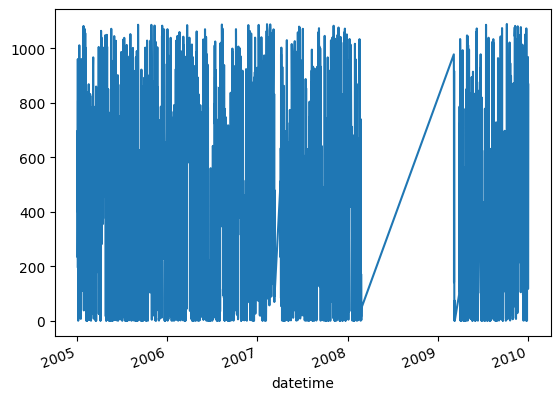

In [48]:
low= wind_ava[wind_ava['label']=="Low"]
low['energy'].plot(rot=20)

<Axes: xlabel='datetime'>

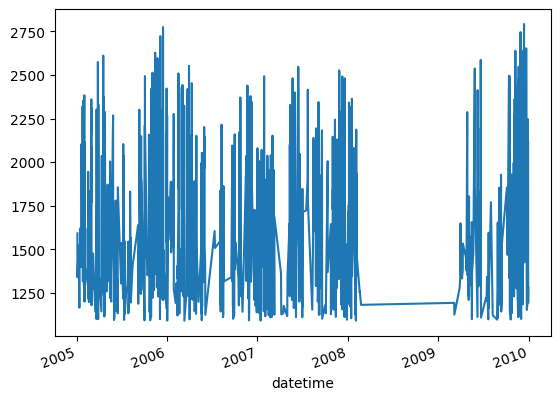

In [49]:
high= wind_ava[wind_ava['label']=="High"]
high['energy'].plot(rot=20)

Una vez obtenidos los dos nuevos datasets,se empela el modelo de regresión obtenido (en este caso, un Árbol de Regresión)para evaluar el error en ambos casos y comprobar la variación que experimenta el MSE en función del nivel energético.

In [55]:
final_model= DecisionTreeRegressor(max_depth= 5, min_samples_split=30)
#1) Energía baja - datos con etiqueta "Low"
final_model.fit(X_low_train, y_low_train)
y_low_pred = final_model.predict(X_low_test)
mse_low = metrics.mean_squared_error(y_low_test, y_low_pred)
r2_low = metrics.r2_score(y_low_test, y_low_pred)
print("Low Energy meassurement results...")
print("Mean Squared Error on Test Set:", mse_low)
print("R2 of final model:", r2_low)

Low Energy meassurement results...
Mean Squared Error on Test Set: 68004.6005623183
R2 of final model: 0.3352865012688546


In [56]:
#Energía alta -datos con etiqueta "High"
final_model.fit(X_high_train, y_high_train)
y_high_pred = final_model.predict(X_high_test)
mse_high = metrics.mean_squared_error(y_high_test, y_high_pred)
r2_high = metrics.r2_score(y_high_test, y_high_pred)
print("High Energy results...")
print("Mean Squared Error on Test Set:", mse_high)
print("R2 of final model:", r2_high)


High Energy results...
Mean Squared Error on Test Set: 148261.26586596787
R2 of final model: 0.2383411798861832


## Conclusiones
Como se puede observar